In [18]:
import pandas as pd
import numpy as np
from scipy import stats
import scipy.io
from scipy.spatial.distance import pdist
from scipy.linalg import cholesky
import matlab.engine as engi
import matlab as mat
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,roc_auc_score,recall_score,precision_score
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import SMOTE
from sklearn.preprocessing import MinMaxScaler
import CFS

import platform
from os import listdir
from os.path import isfile, join
from glob import glob
from pathlib import Path
import sys
import os
import copy
import traceback
from pathlib import Path

import matplotlib.pyplot as plt

In [2]:
def load_data(project):
    understand_path = 'data/understand_files/' + project + '_understand.csv'
    commit_guru_path = 'data/commit_guru/' + project + '.csv'
    understand_df = pd.read_csv(understand_path)
    understand_df = understand_df.dropna(axis = 1,how='all')
#     print(understand_df)
#     understand_df = understand_df.drop(['Kind','Name'],axis = 1)
#     understand_df = understand_df[['Bugs', 'Name', 'commit_hash', 'AvgCyclomatic', 'AvgCyclomaticModified',
#        'AvgCyclomaticStrict', 'AvgEssential', 'AvgLine', 'AvgLineBlank',
#        'AvgLineCode', 'AvgLineComment', 'CountClassBase', 'CountClassCoupled',
#        'CountClassCoupledModified', 'CountClassDerived',
#        'CountDeclClassMethod', 'CountDeclClassVariable',
#        'CountDeclInstanceMethod', 'CountDeclInstanceVariable',
#        'CountDeclMethod', 'CountDeclMethodAll', 'CountDeclMethodDefault',
#        'CountDeclMethodPrivate', 'CountDeclMethodProtected',
#        'CountDeclMethodPublic', 'CountLine', 'CountLineBlank', 'CountLineCode',
#        'CountLineCodeDecl', 'CountLineCodeExe', 'CountLineComment',
#        'CountSemicolon', 'CountStmt', 'CountStmtDecl', 'CountStmtExe',
#        'MaxCyclomatic', 'MaxCyclomaticModified', 'MaxCyclomaticStrict',
#        'MaxEssential', 'MaxInheritanceTree', 'MaxNesting',
#        'PercentLackOfCohesion', 'PercentLackOfCohesionModified',
#        'RatioCommentToCode', 'SumCyclomatic', 'SumCyclomaticModified',
#        'SumCyclomaticStrict', 'SumEssential']]

    commit_guru_df = pd.read_csv(commit_guru_path)
    cols = understand_df.columns.tolist()
    commit_guru_df = commit_guru_df.drop(labels = ['parent_hashes','author_name','author_name',
                                                   'author_email','fileschanged','author_date',
                                                   'author_date_unix_timestamp', 'commit_message',
                                                  'classification', 'fix', 'contains_bug','fixes',],axis=1)
    
#     print(cols[3:len(cols)-2])
#     print(understand_df.shape)
    understand_df = understand_df.drop_duplicates(cols[3:len(cols)-2])
#     print(understand_df.shape)
    df = understand_df.merge(commit_guru_df,on='commit_hash')
    cols = df.columns.tolist()
    cols = cols[1:] + [cols[0]]
    df = df[cols]
#     print(df.columns)
    df = df.drop(labels = ['Kind','Name','commit_hash'],axis=1)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
#     df,cols = apply_cfs(df)
    y = df.Bugs
    X = df.drop('Bugs',axis = 1)
    cols = X.columns
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X,columns = cols)
#     X = X.drop(labels = ['la', 'ld', 'nf', 'ns', 'nd',
#        'entrophy', 'ndev', 'lt', 'nuc', 'age', 'exp', 'rexp', 'sexp'], axis = 1)
    return X,y
def apply_smote(df):
    cols = df.columns
    smt = SMOTE.smote(df)
    df = smt.run()
    df.columns = cols
    return df

def apply_cfs(df):
        y = df.Bugs.values
        X = df.drop(labels = ['Bugs'],axis = 1)
        X = X.values
        selected_cols = CFS.cfs(X,y)
        cols = df.columns[[selected_cols]].tolist()
        cols.append('Bugs')
        return df[cols],cols

In [12]:
def run_self(project):
    X,y = load_data(project)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=18)
    df_smote = pd.concat([X_train,y_train],axis = 1)
    df_smote = apply_smote(df_smote)
    y_train = df_smote.Bugs
    X_train = df_smote.drop('Bugs',axis = 1)
    clf = LogisticRegression()
    clf.fit(X_train,y_train)
    predicted = clf.predict(X_test)
    print(classification_report(y_test, predicted))
    recall = recall_score(y_test, predicted,average='binary')
    precision = precision_score(y_test, predicted,average='binary')
    return recall,precision

In [13]:
_dir = 'data/understand_files/'
projects = [f.split('_understand')[0] for f in listdir(_dir) if isfile(join(_dir, f))]

In [16]:
precision = []
recall = []
for project in projects:
    try:
        if project == '.DS_Store':
            continue
    #     if project != 'guice':
    #         continue
        print("+++++++++++++++++   "  + project + "  +++++++++++++++++")
        r,p = run_self(project)
        recall.append(r)
        precision.append(p)
    except Exception as e:
        print(e)
        continue

+++++++++++++++++   metacat  +++++++++++++++++
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       377
           1       0.78      0.83      0.80       455

    accuracy                           0.78       832
   macro avg       0.77      0.77      0.77       832
weighted avg       0.78      0.78      0.77       832

0.7699507389162561
+++++++++++++++++   phoenicis  +++++++++++++++++
This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0
+++++++++++++++++   vim.js  +++++++++++++++++
"['Kind'] not found in axis"
+++++++++++++++++   loklak_wok_android  +++++++++++++++++
              precision    recall  f1-score   support

           0       0.64      0.50      0.56        32
           1       0.71      0.82      0.76        49

    accuracy                           0.69        81
   macro avg       0.68      0.66      0.66        81
weighted avg       0.68      0.69      0.68       

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       342
           1       0.86      0.91      0.89       464

    accuracy                           0.87       806
   macro avg       0.87      0.86      0.86       806
weighted avg       0.87      0.87      0.87       806

0.8582501512401693
+++++++++++++++++   mopidy  +++++++++++++++++
This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0
+++++++++++++++++   pojobuilder  +++++++++++++++++
              precision    recall  f1-score   support

           0       0.67      0.64      0.66       185
           1       0.81      0.82      0.82       337

    accuracy                           0.76       522
   macro avg       0.74      0.73      0.74       522
weighted avg       0.76      0.76      0.76       522

0.734084529633491
+++++++++++++++++   greenDAO  +++++++++++++++++
"['Kind'] not found in axis"
+++++++++++++++++   mezzanine  +

              precision    recall  f1-score   support

           0       0.99      0.89      0.94       890
           1       0.59      0.94      0.73       153

    accuracy                           0.90      1043
   macro avg       0.79      0.91      0.83      1043
weighted avg       0.93      0.90      0.91      1043

0.9149702577660278
+++++++++++++++++   picasso  +++++++++++++++++
              precision    recall  f1-score   support

           0       0.74      0.76      0.75       328
           1       0.76      0.74      0.75       338

    accuracy                           0.75       666
   macro avg       0.75      0.75      0.75       666
weighted avg       0.75      0.75      0.75       666

0.7478712656949055
+++++++++++++++++   react-native-screens  +++++++++++++++++
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        18
           1       1.00      0.86      0.92        21

    accuracy                         

              precision    recall  f1-score   support

           0       0.76      0.73      0.75      1281
           1       0.59      0.64      0.61       795

    accuracy                           0.69      2076
   macro avg       0.68      0.68      0.68      2076
weighted avg       0.70      0.69      0.70      2076

0.6827979320401218
+++++++++++++++++   beets  +++++++++++++++++
This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0
+++++++++++++++++   swipe-button  +++++++++++++++++
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.78      1.00      0.88         7

    accuracy                           0.93        27
   macro avg       0.89      0.95      0.91        27
weighted avg       0.94      0.93      0.93        27

0.9500000000000001
+++++++++++++++++   fdb-record-layer  +++++++++++++++++
              precision    recall  f1-score   suppor

              precision    recall  f1-score   support

           0       0.74      0.71      0.72       106
           1       0.46      0.49      0.47        53

    accuracy                           0.64       159
   macro avg       0.60      0.60      0.60       159
weighted avg       0.64      0.64      0.64       159

0.5990566037735848
+++++++++++++++++   Telegram  +++++++++++++++++
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      4952
           1       0.67      0.81      0.74      2118

    accuracy                           0.83      7070
   macro avg       0.79      0.82      0.80      7070
weighted avg       0.84      0.83      0.83      7070

0.8221720776298548
+++++++++++++++++   hollow  +++++++++++++++++
              precision    recall  f1-score   support

           0       0.79      0.84      0.81       765
           1       0.53      0.44      0.48       305

    accuracy                           0.73      1

              precision    recall  f1-score   support

           0       0.91      0.80      0.85      2225
           1       0.32      0.56      0.41       383

    accuracy                           0.76      2608
   macro avg       0.62      0.68      0.63      2608
weighted avg       0.83      0.76      0.79      2608

0.6793305365681932
+++++++++++++++++   BiglyBT  +++++++++++++++++
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      3960
           1       0.63      0.65      0.64      1568

    accuracy                           0.79      5528
   macro avg       0.75      0.75      0.75      5528
weighted avg       0.80      0.79      0.80      5528

0.7513379973201402
+++++++++++++++++   archaius  +++++++++++++++++
              precision    recall  f1-score   support

           0       0.78      0.66      0.71       174
           1       0.44      0.60      0.51        80

    accuracy                           0.64      

              precision    recall  f1-score   support

           0       0.91      0.82      0.86        72
           1       0.92      0.96      0.94       148

    accuracy                           0.91       220
   macro avg       0.91      0.89      0.90       220
weighted avg       0.91      0.91      0.91       220

0.8894519519519519
+++++++++++++++++   opsu  +++++++++++++++++
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       414
           1       0.79      0.83      0.81       502

    accuracy                           0.78       916
   macro avg       0.78      0.78      0.78       916
weighted avg       0.78      0.78      0.78       916

0.778865215466636
+++++++++++++++++   org.alloytools.alloy  +++++++++++++++++
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       138
           1       0.90      0.77      0.83       168

    accuracy                           0.

Text(0.5, 1.0, 'Recall')

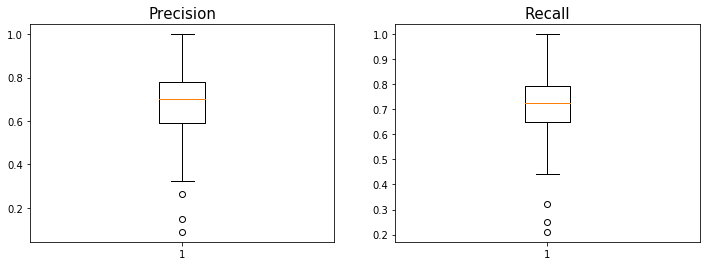

In [25]:
fig = plt.figure(num=None, figsize = (12,4), facecolor='w', edgecolor='k')
ax = fig.add_subplot(121)
ax.boxplot(precision)
ax.set_title('Precision',size = 15)
ax = fig.add_subplot(122)
ax.boxplot(recall)
ax.set_title('Recall',size = 15)

Text(0, 0.5, 'Recall')

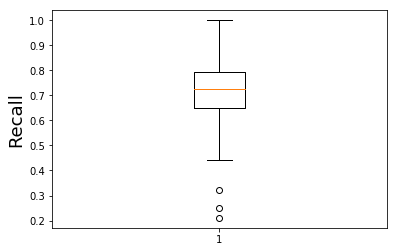

In [22]:
plt.boxplot(recall)
plt.ylabel('Recall',fontsize=18)